In [10]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [11]:
import torch

# <h1><center>**Ladle furnace benchmark**</center></h1>


In this example, we'll be optimising a detector for the task described in our initial [TomOpt paper](https://arxiv.org/abs/2309.14027). We aim at demonstrating the main features of TomOpt in the context of a specific muon scattering tomography task: infering the fill level of a furnace ladle. Firstly, we will introduce a sub-optimal detector configuration and study its inference capabilities. Secondly, we will proceed to a first step of optimization and evaluate the inference improvements made. Then, a second round of optimisation will take place, after 

In [12]:
NAME = 'ladle_furnace'

In [13]:
DEVICE = torch.device('cpu')

## Setup volume

We'll begin by defining our volume, consisting of the detectors and passive volume. We are free to choose any detector configuration we want: number of detector panels, their position, efficiencies and spatial resolution. For the sake of simplicity, we will use the `get_initial_detector` function of the `ladle_furnace` benchmark module:

In [14]:
from tomopt.benchmarks.ladle_furnace import get_initial_detector
from tomopt.volume import Volume

In [15]:
volume = Volume(get_initial_detector(device=DEVICE), budget=6)
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([1.4800]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([1.4700]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([1.4600]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (3): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0., 0.]), z=tensor([1.4500]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at 

We can visualise the layout of this in 3D. Note the closeness of the panels, and their offset from the passive volume. We do not expect this detector to perform well, but we can optimise it to a better configuration.

In [16]:
%matplotlib notebook
volume.draw(xlim=(-2,2), ylim=(-2,2), zlim=(-2,2))

<IPython.core.display.Javascript object>

In [17]:
%matplotlib inline

## Data generation

Now we'll need to define how to generate example passive volumes. The `LadleFurnacePassiveGenerator` class will create layouts based on varying fill-heights of a furnace ladle, with varying levels of slag.

In [18]:
from tomopt.benchmarks.ladle_furnace import LadleFurnacePassiveGenerator

In [19]:
passive_gen = LadleFurnacePassiveGenerator(volume)

For a single training epoch, we'll generate 5 volumes at a range of fill-heights. The 10cm of slag will be present for ever volume.

In [20]:
N_PASSIVES_PER_H = 5

In [21]:
HEIGHTS = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

In [22]:
from tomopt.optimisation import PassiveYielder

In [23]:
trn_passives = PassiveYielder([passive_gen._generate(fixed_mat_z=h, fixed_slag_z=h+0.1)
                               for _ in range(N_PASSIVES_PER_H) for h in HEIGHTS])

Let's visualise one these volume layouts by repurposing one of the visualisers in TomOpt

In [24]:
f,t = trn_passives.passives[20]
volume.load_rad_length(f, t)

In [25]:
from tomopt.plotting import plot_pred_true_x0
from tomopt.utils import x0targs_to_classtargs
from tomopt.core import X0

In [26]:
x02id = {X0['air']:0, X0['slag']:1, X0['hot liquid steel']:2, X0['steel']:3}

In [27]:
x02id

{303.9: 0, 0.08211: 1, 0.01991: 2, 0.01782: 3}

In [28]:
true = volume.get_rad_cube()
class_true = x0targs_to_classtargs(true, x02id)

In [29]:
import numpy as np

Absolute fill height tensor([1.])


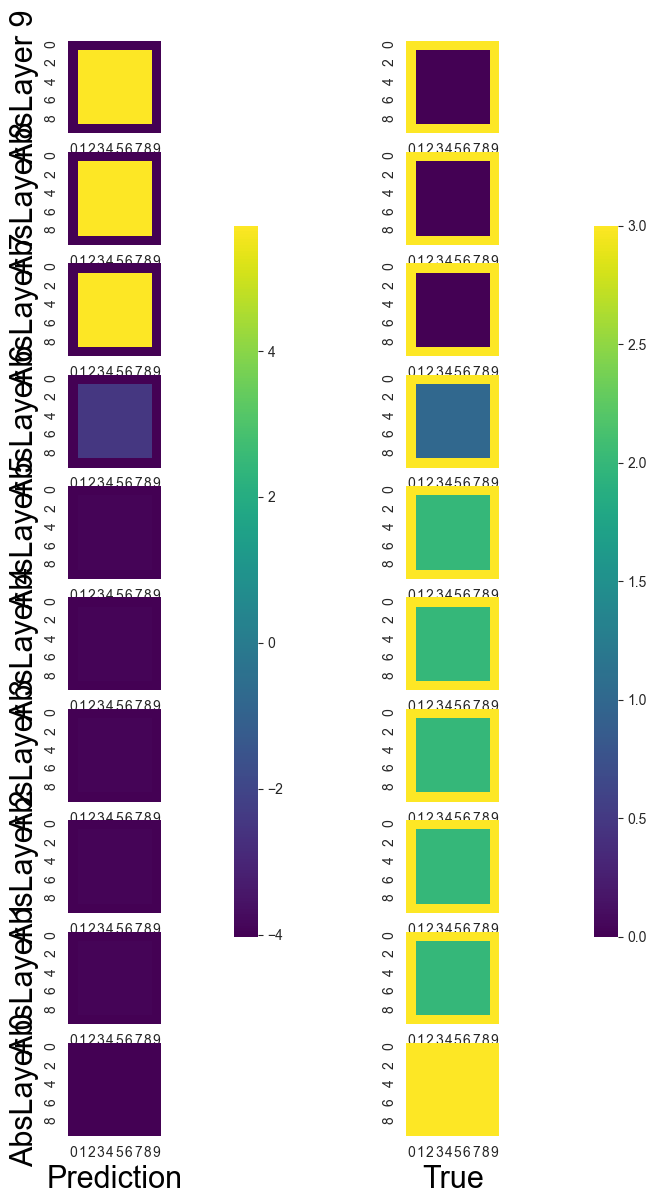

In [30]:
print("Absolute fill height", t)
plot_pred_true_x0(np.log(true), class_true)

Ignoring the predicted and true labels, on the right is the layers of the ladle, coloured by voxel material: Yellow = ladle (steel); Green = liquid steel; Blue = Slag; Purple = Air.

On the left is the same set of layers, but coloured by material log_10 of the X0. We can see that the metals have very similar X0, but they are slightly distinguishable from the slag.

## Optimiser setup

We'll define separate optimisers for panels above and below the passive volume, and each of their xy, or z positions. Additionally, we'll have a separate optimiser to adjust the budget distribution to the panels.

In [31]:
lu, ld = volume.get_detectors()[0], volume.get_detectors()[1]
opts = {'xy_pos_upper':torch.optim.SGD((p.xy for p in lu.panels), lr=3.0),
        'z_pos_upper':torch.optim.SGD((p.z for p in lu.panels), lr=0.01),
        'xy_pos_lower':torch.optim.SGD((p.xy for p in ld.panels), lr=3.0),
        'z_pos_lower':torch.optim.SGD((p.z for p in ld.panels), lr=0.01),
        'budget_weights':torch.optim.SGD((p for p in [volume.budget_weights]), lr=0.01)
       }

Now we'll create a volume wrapper to contain the optimisers, volume, and inference methods. The inference method is described in the paper, and uses the mean of the POCA z-positions to provide a prediction of the fill-height.

In [32]:
from tomopt.optimisation import ArbVolumeWrapper, VolumeMSELoss
from tomopt.benchmarks.ladle_furnace import PocaZLadleFurnaceFillLevelInferrer
from functools import partial

In [33]:
wrapper = ArbVolumeWrapper(volume,
                             opts=opts,
                             loss_func=VolumeMSELoss(target_budget=None),
                             partial_volume_inferrer=partial(PocaZLadleFurnaceFillLevelInferrer, smooth=1.0))

# Initial performance

Let's evaluate the initial performance of our detector. We'll do this on a test dataset of 100 passive volumes at each of our specified heights.

In [34]:
test_passives = PassiveYielder([passive_gen._generate(fixed_mat_z=h, fixed_slag_z=h+0.1)
                               for _ in range(100//len(HEIGHTS)) for h in HEIGHTS])
len(test_passives)

96

For evaluation of the predictions, we'll want to also have access to the the true fill-height. We'll use the `VolumeTargetPredHandler` to ensure this information isn't lost.

In [35]:
from tomopt.optimisation import VolumeTargetPredHandler, MuonResampler

In [36]:
preds = wrapper.predict(test_passives,
                n_mu_per_volume=1000,
                mu_bs=1000,
                pred_cb=VolumeTargetPredHandler(),
                cbs=[MuonResampler()])

/home/geant/miniforge3/envs/tomopt/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


The returned predictions consist of pairs of predicted and true fill-heights. Lets plot out the bias and MSE:

In [37]:
preds[:5]

[(array([0.9297048], dtype=float32), array([0.6], dtype=float32)),
 (array([0.8860661], dtype=float32), array([0.7], dtype=float32)),
 (array([0.84124225], dtype=float32), array([0.8], dtype=float32)),
 (array([0.8216759], dtype=float32), array([0.9], dtype=float32)),
 (array([0.8439798], dtype=float32), array([1.], dtype=float32))]

In [38]:
import pandas as pd

In [39]:
df_start = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_start['gen_target'] = volume.passive_size*((df_start.gen_target/volume.passive_size)//1)
df_start['bias'] = (df_start.gen_target-df_start.pred)
df_start['mse'] = df_start.bias**2

In [40]:
df_start.mse.mean()

0.04663241

In [41]:
!mkdir {NAME}_plots

mkdir: cannot create directory ‘ladle_furnace_plots’: File exists


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from tomopt.plotting import STYLE, TK_COL, TK_SZ, LBL_COL, LBL_SZ, W_MID, H_MID

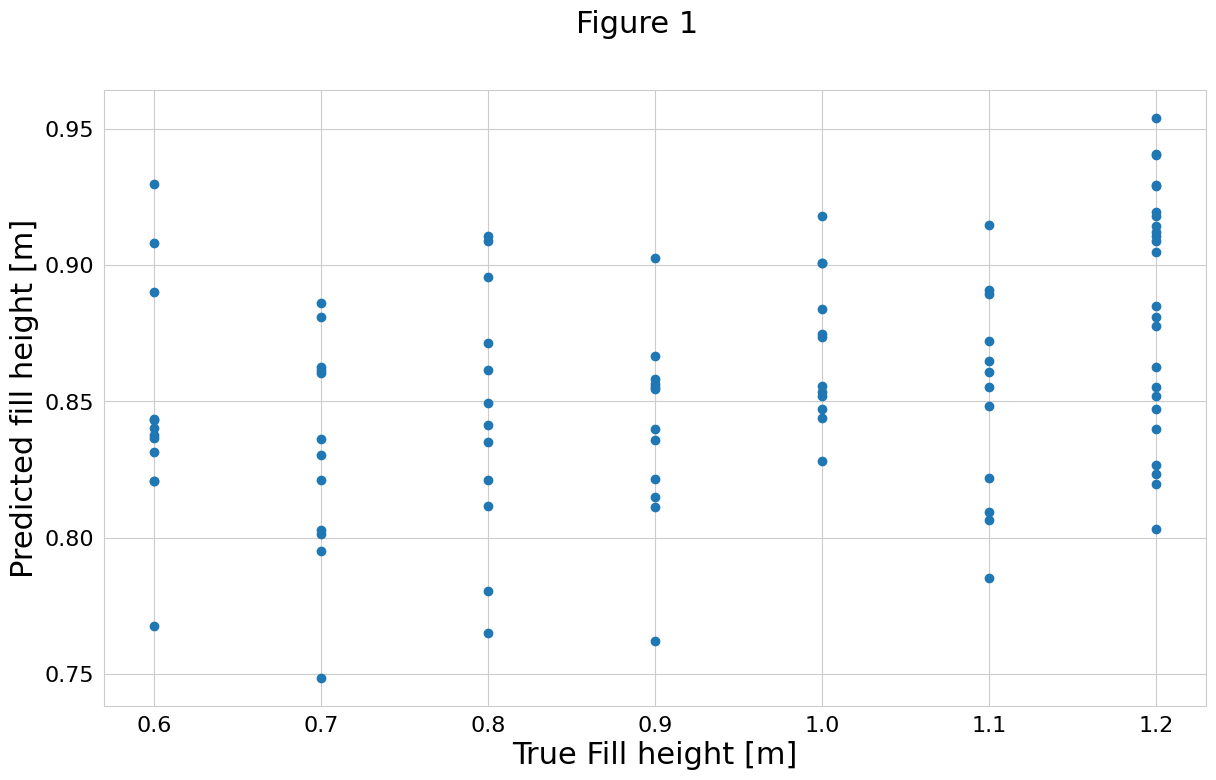

In [43]:
with sns.axes_style(**STYLE):
    plt.figure(figsize=(W_MID, H_MID))
    plt.suptitle("Figure 1", fontsize=LBL_SZ, color=LBL_COL)
    plt.scatter(df_start.gen_target, df_start.pred)
    plt.xlabel('True Fill height [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.ylabel('Predicted fill height [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.xticks(fontsize=TK_SZ, color=TK_COL)
    plt.yticks(fontsize=TK_SZ, color=TK_COL)

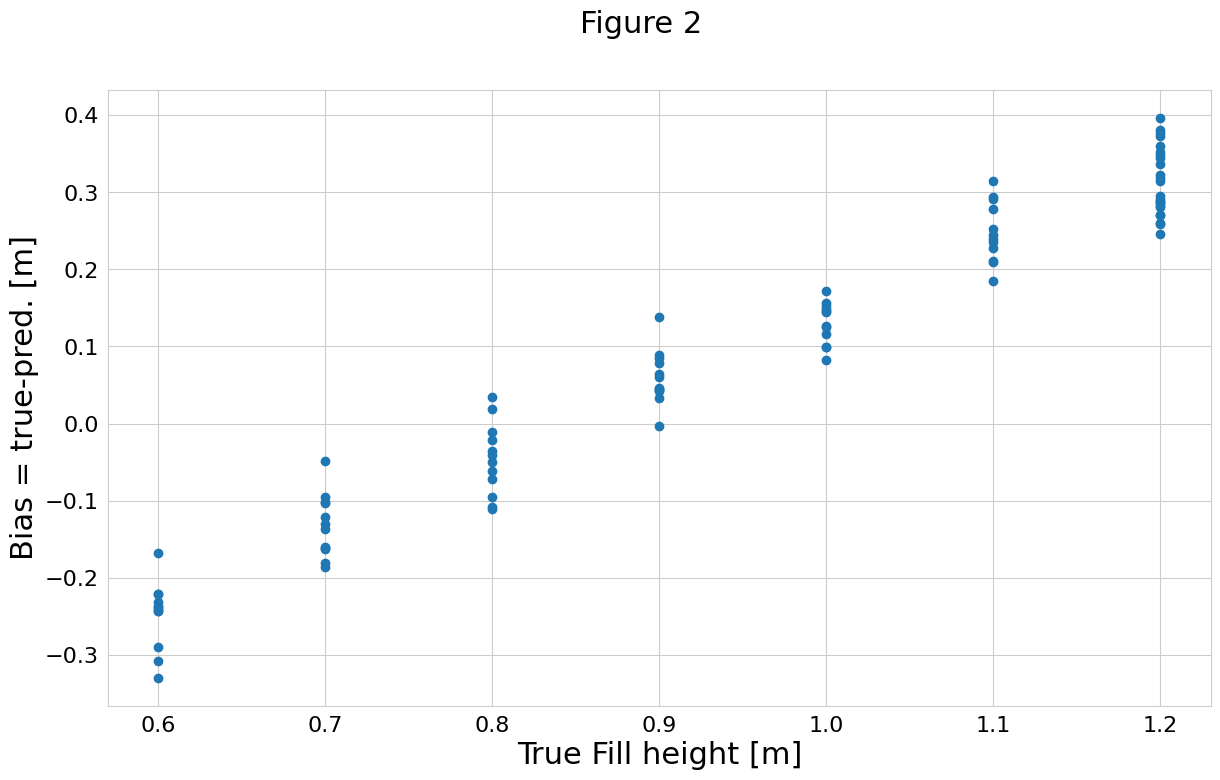

In [44]:
with sns.axes_style(**STYLE):
    plt.figure(figsize=(W_MID, H_MID))
    plt.suptitle("Figure 2", fontsize=LBL_SZ, color=LBL_COL)
    plt.scatter(df_start.gen_target, df_start.bias)
    plt.xlabel('True Fill height [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.ylabel('Bias = true-pred. [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.xticks(fontsize=TK_SZ, color=TK_COL)
    plt.yticks(fontsize=TK_SZ, color=TK_COL)

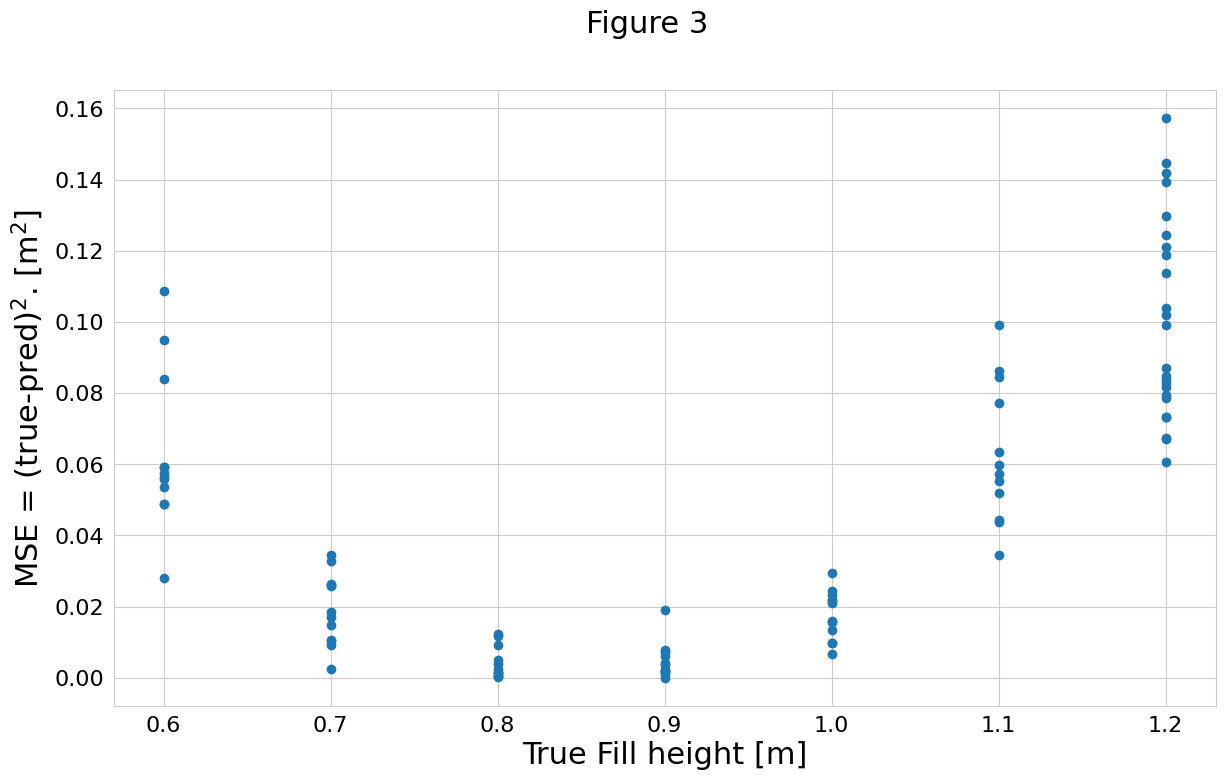

In [45]:
with sns.axes_style(**STYLE):
    plt.figure(figsize=(W_MID, H_MID))
    plt.suptitle("Figure 3", fontsize=LBL_SZ, color=LBL_COL)
    plt.scatter(df_start.gen_target, df_start.mse)
    plt.xlabel('True Fill height [m]', fontsize=LBL_SZ, color=LBL_COL)
    plt.ylabel('MSE = (true-pred)$^2$. [m$^2$]', fontsize=LBL_SZ, color=LBL_COL)
    plt.xticks(fontsize=TK_SZ, color=TK_COL)
    plt.yticks(fontsize=TK_SZ, color=TK_COL)

## Bias correction

Looking at Figure 1, we can see that the predictions for varying true fill-heights are quite indistinguishable due to their spread, and are also biased. We can attempt to correct for this bias using a linear rescaling of the predictions.

Let's grab the predicted and true fill-heights and fit a linear function to them.

In [46]:
from torch import nn, Tensor

In [47]:
x = Tensor(df_start.pred.values)[:,None]
y = Tensor(df_start.gen_target.values)[:,None]

In [48]:
corr_layer = nn.Linear(1,1)
corr_layer.weight.data[0] = 1.0
corr_layer.bias.data[0] = 0.0

In [49]:
opt = torch.optim.SGD(corr_layer.parameters(), lr=3e-1)
mse = nn.MSELoss()

In [50]:
for i in range(10000):
    y_pred = corr_layer(x)
    loss = mse(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(loss)

tensor(0.0392, grad_fn=<MseLossBackward0>)


In [51]:
corr_layer.weight, corr_layer.bias

(Parameter containing:
 tensor([[1.7326]], requires_grad=True),
 Parameter containing:
 tensor([-0.5477], requires_grad=True))

Now we can use the correction to debias the raw predictions. The effectiveness of this debiassing process depends heavily on how well separated the predictions are for different true fill-heights.

In [52]:
df_start['new_pred'] = corr_layer(Tensor(df_start.pred.values[:,None])).detach().cpu().numpy()
df_start['new_bias'] = df_start.gen_target-df_start.new_pred
df_start['new_mse'] = df_start.new_bias**2

In [53]:
df_start.new_mse.mean(), df_start.new_bias.abs().mean()

(0.03917697, 0.16680014)

In [54]:
from tomopt.benchmarks.ladle_furnace import compare_raw_init_to_bias_corrected_init

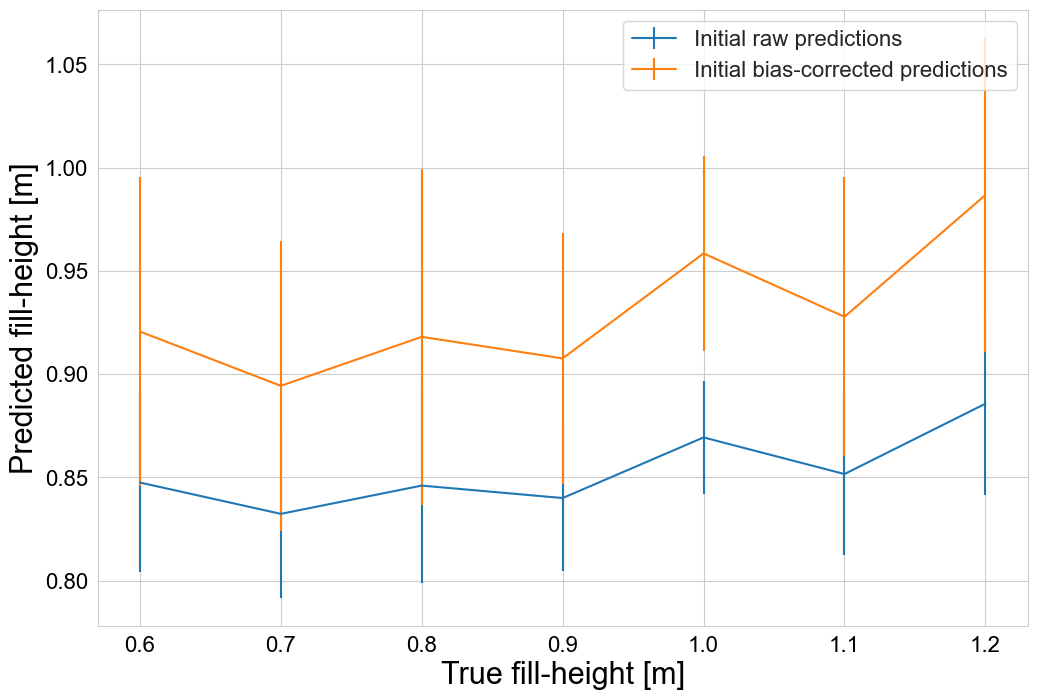

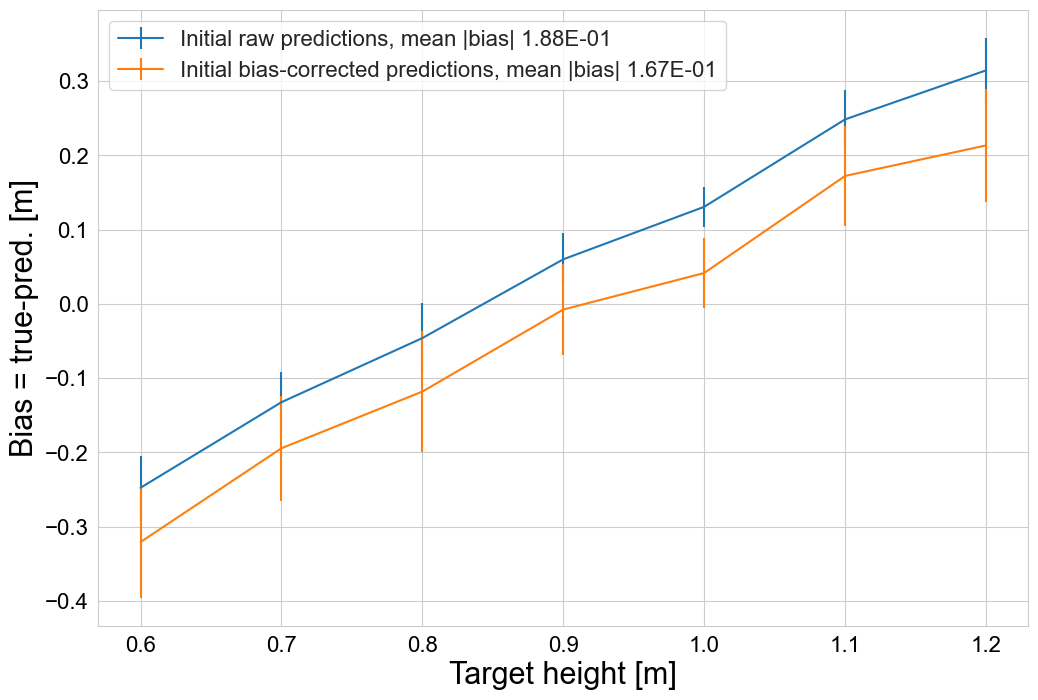

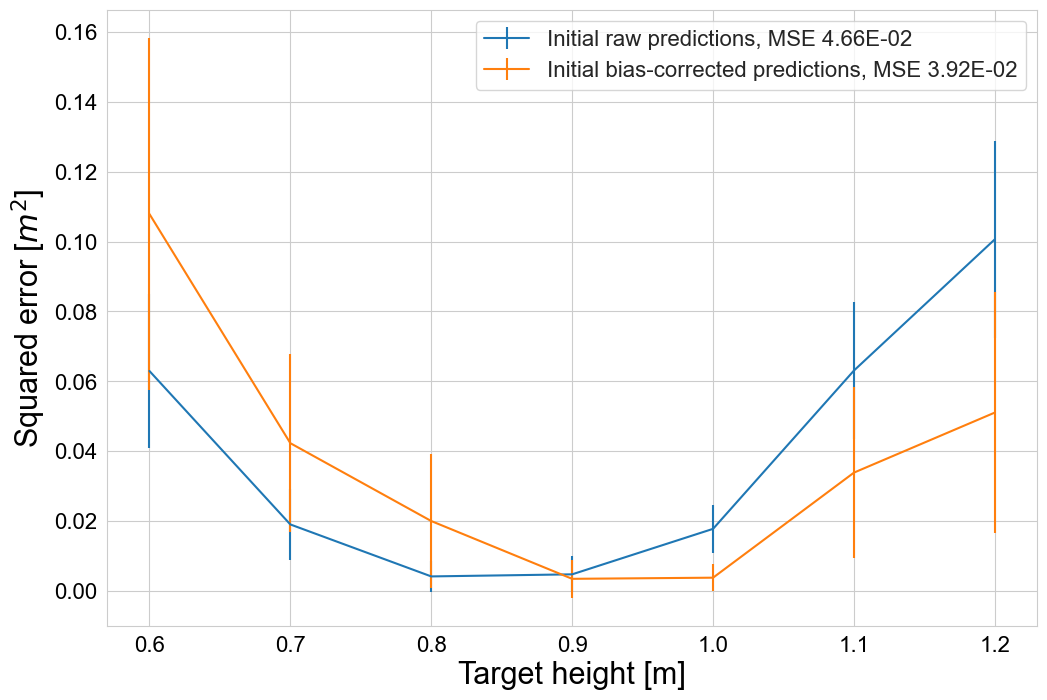

In [55]:
compare_raw_init_to_bias_corrected_init(df_start, NAME)

So, the linear rescaling process was able to reduce the bias, at the cost of an increase in variance, however there is a slight overall decrease in the MSE.

# Optimisation

Now we want to try to optimise the detector to improve the fill-height prediction. As the predictions change, so will the bias-correction that should be applied to them, so we'll use a callback to refit the bias correction after every update to the detector.

In [56]:
from tomopt.benchmarks.ladle_furnace import LinearCorrectionCallback

We don't have a good idea about what learning rates will be suitable for optimisation of the parameters, however we can have an reasonable guess about how much each update should correspond to in physical units, so by monitoring the loss-gradients received by the parameters, we can estimate suitable learning rates that correspond to the desired update. We'll aim for 1cm updates for the xyz parameters.

In [57]:
from tomopt.optimisation import OptConfig

In [3]:
opt_config = OptConfig(n_warmup=5, rates={'budget_weights':0.1,'xy_pos_upper':0.01, 'z_pos_upper':0.01, 'xy_pos_lower':0.01, 'z_pos_lower':0.01})

The loss function we use is also described in our paper, and aims to quantify how different predictions generally are for different fill-heights. Having predictions be monotonic with true fill-height, and be easily distinguishable make the debiassing process easier.

We'll run the warm-up optimisation for 5 epochs to get an idea of suitable learning rates for our optimisers. During this time, the detectors won't update.

In [58]:
from tomopt.benchmarks.ladle_furnace import SpreadRangeLoss
from tomopt.optimisation import NoMoreNaNs, PanelCentring, PanelMetricLogger

In [59]:
linear_correction = LinearCorrectionCallback(partial(torch.optim.SGD, lr=3e-1), init_weight=corr_layer.weight.item(), init_bias=corr_layer.bias.item())

1 warmup callbacks found, with a total warmup period of 5 epochs.


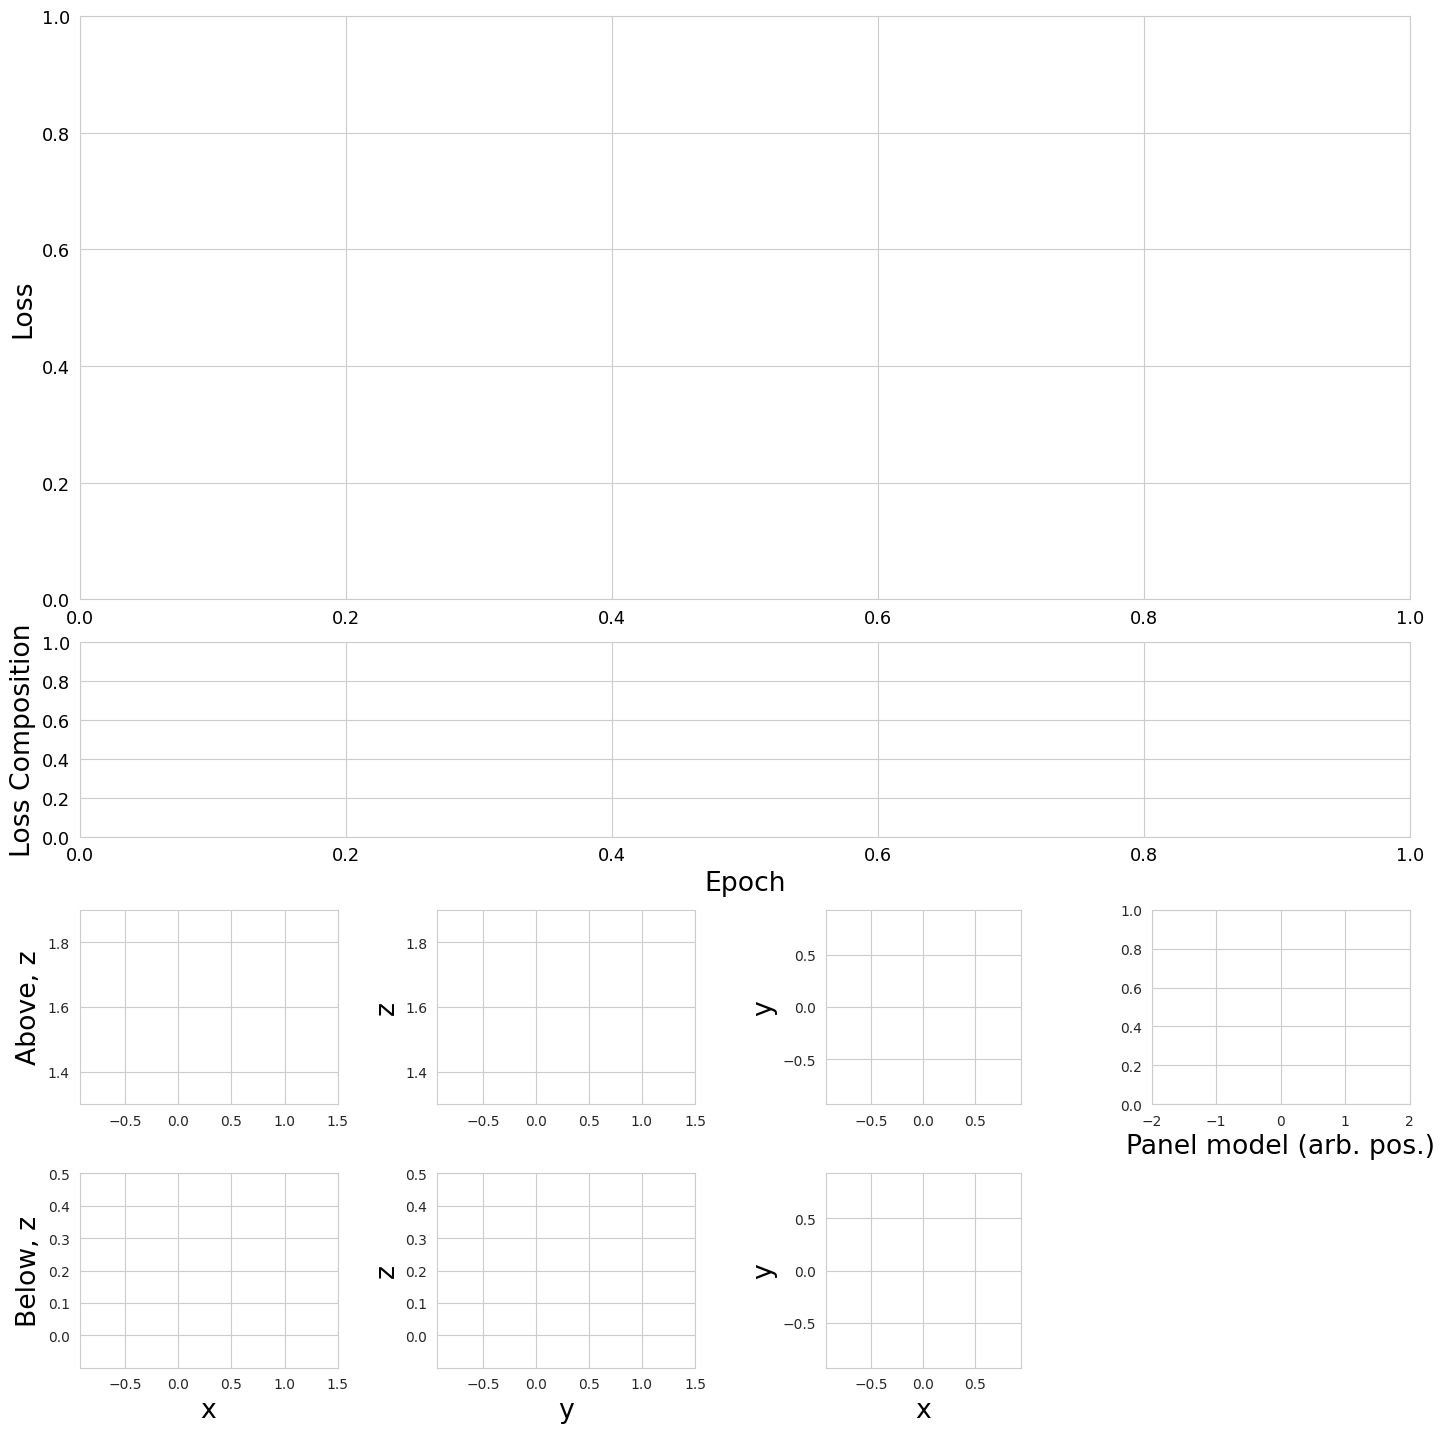

Automatically setting cost coefficient to 0.041926078498363495
OptConfig: Optimiser warm-up completed
+----------------+-------------+------------------------+
|     Param      | Median Grad |           LR           |
+----------------+-------------+------------------------+
| budget_weights | 0.029611599 |    3.37705508615574    |
|  xy_pos_upper  |  0.10808165 |   0.0925226405810261   |
|  z_pos_upper   |  29.894382  | 0.00033451100746966205 |
|  xy_pos_lower  | 0.070894234 |  0.14105519521635923   |
|  z_pos_lower   |   54.27498  | 0.00018424696335218367 |
+----------------+-------------+------------------------+


<Figure size 1422.22x1422.22 with 0 Axes>

In [60]:
_ = wrapper.fit(n_epochs=5,
                passive_bs=len(trn_passives),
                n_mu_per_volume=1000,
                mu_bs=250,
                trn_passives=trn_passives,
                val_passives=None,
                cbs=[MuonResampler(), linear_correction, SpreadRangeLoss(), NoMoreNaNs(),
                     opt_config,
                     PanelCentring(), PanelMetricLogger()])

In [61]:
opt_config.lrs

{'budget_weights': 3.37705508615574,
 'xy_pos_upper': 0.0925226405810261,
 'z_pos_upper': 0.00033451100746966205,
 'xy_pos_lower': 0.14105519521635923,
 'z_pos_lower': 0.00018424696335218367}

opt_config.lrs = {'budget_weights': 3.570020153852333,
 'xy_pos_upper': 0.08599801384923361,
 'z_pos_upper': 0.0002922350647073296,
 'xy_pos_lower': 0.19964097335174785,
 'z_pos_lower': 0.0003664348352403338}

From the warm-up learning rate search, we have settings for the optimiser that should correspond to the desired update rates. For the actual training, we'll use a learning rate schedule called OneCycle, which requires three settings for the learning rates at different stages of training. We'll set these based on the results of the learning-rate search. In case anything goes wrong in the optimisation, we'll save a copy of the detector after every epoch. Additionally, we can expect the smoothness of the differentiable model of the detectors (`SigmoidDetectorPanel`) to have an impact on the performance. We'll use a callback to adjust it during optimisation such that it begins very smooth (and is sensitive to xy-location) and gradually adjust it such that it becomes more physical (lessens sensitivity to xy-position, and increases sensitivity to z-position).

In [62]:
from pathlib import Path
from tomopt.optimisation import  EpochSave, OneCycle, SigmoidPanelSmoothnessSchedule

0 warmup callbacks found, with a total warmup period of 0 epochs.


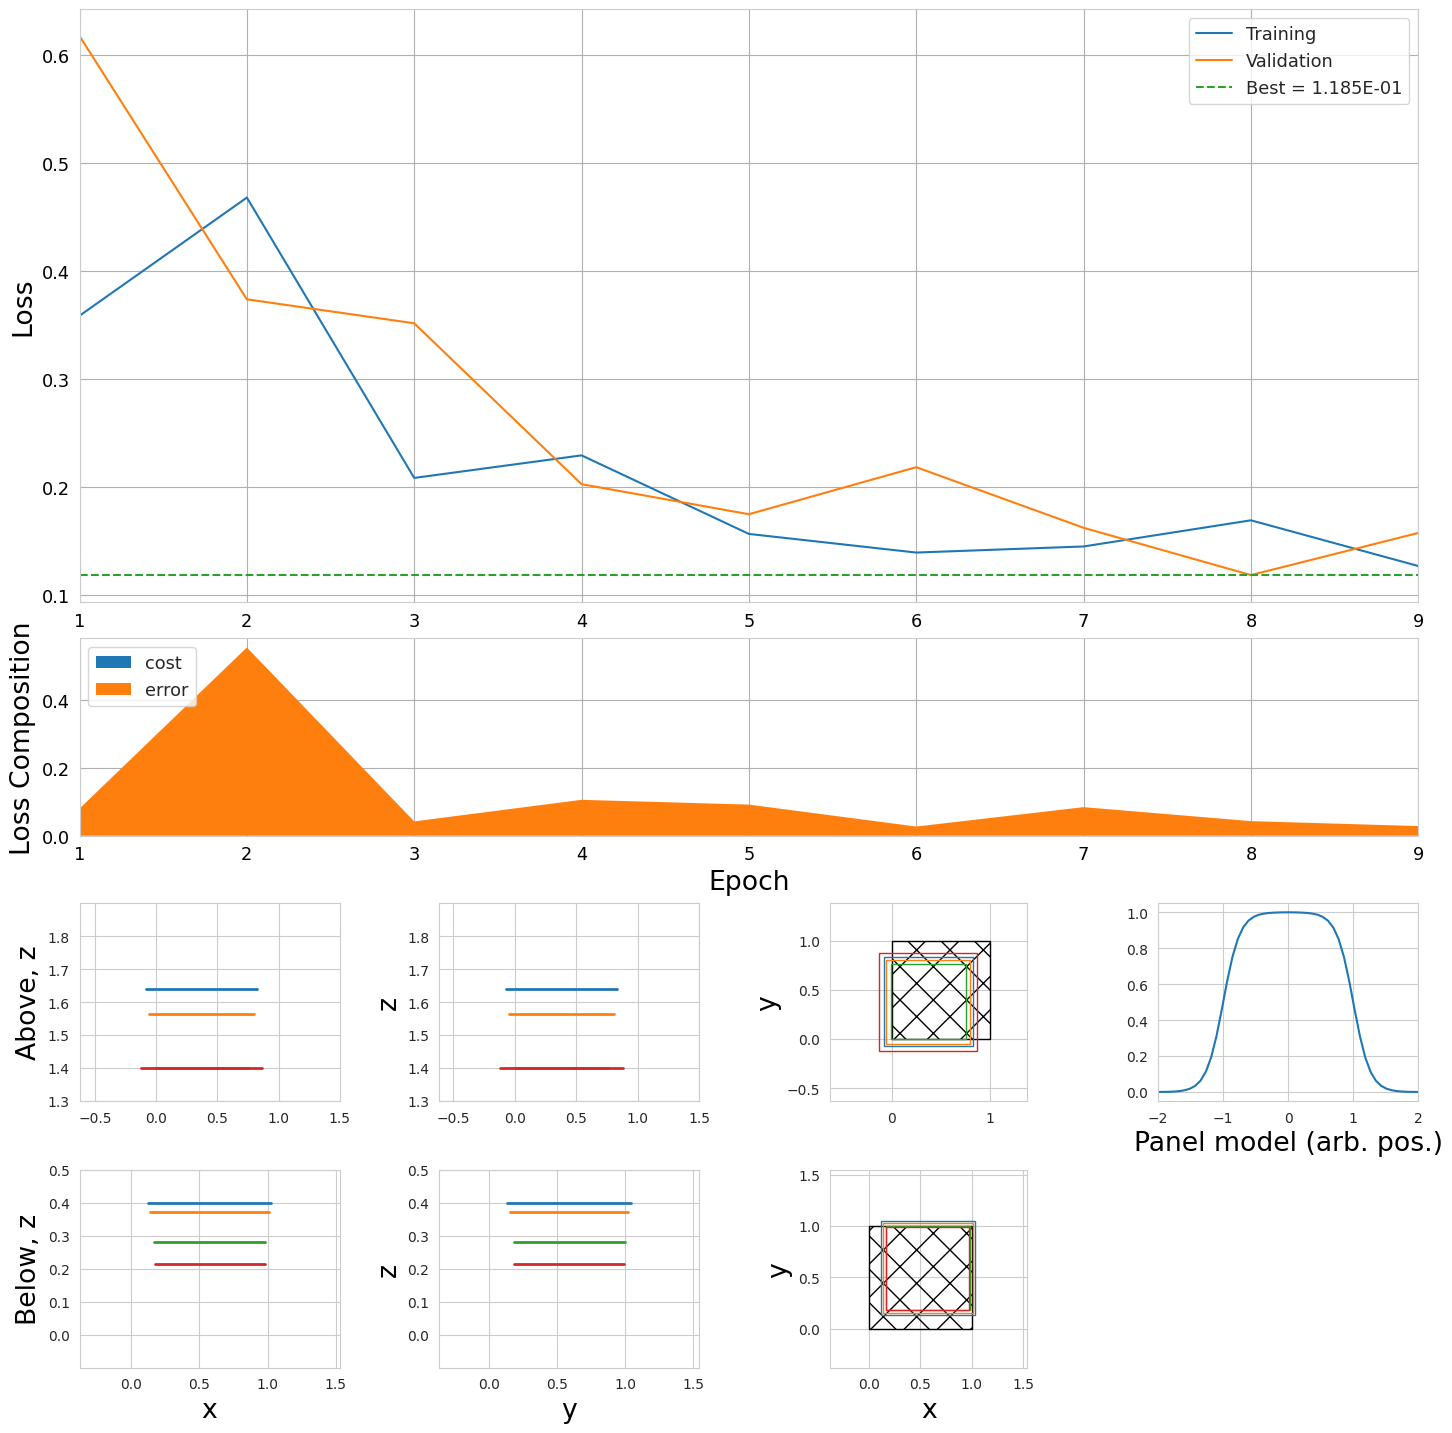

/home/geant/Desktop/TASKS/TomOpt/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:219: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


TypeError: nan_to_num(): argument 'input' (position 1) must be Tensor, not NoneType

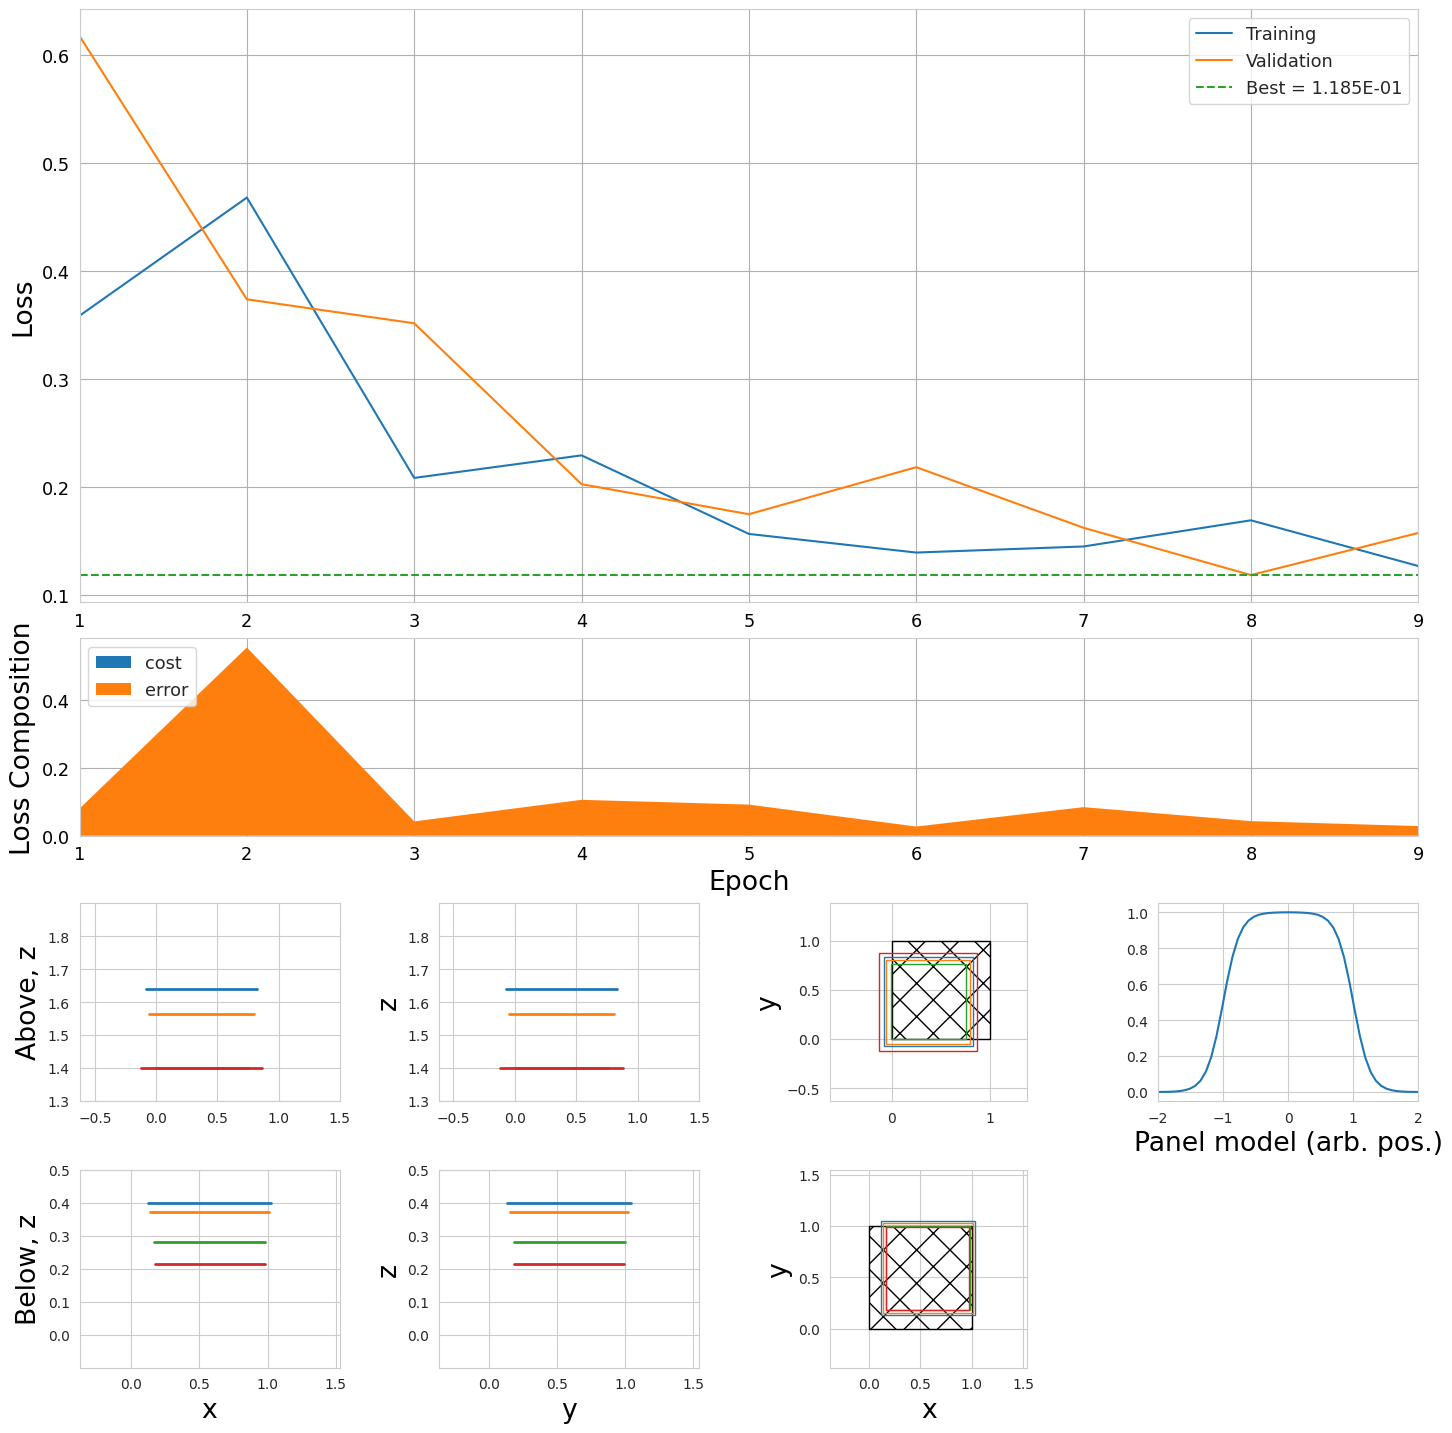

In [63]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=len(trn_passives),
                n_mu_per_volume=1000,
                mu_bs=250,
                trn_passives=trn_passives,
                val_passives=trn_passives,
                cb_savepath=Path(f'train_weights_{NAME}_1'),
                cbs=[EpochSave(),
                    OneCycle('xy_pos_upper', warmup_length=5, init_lr=2*opt_config.lrs['xy_pos_upper'], mid_lr=10*opt_config.lrs['xy_pos_upper'], final_lr=opt_config.lrs['xy_pos_upper']/5),
                    OneCycle('z_pos_upper', warmup_length=5, init_lr=2*opt_config.lrs['z_pos_upper'], mid_lr=10*opt_config.lrs['z_pos_upper'], final_lr=opt_config.lrs['z_pos_upper']),
                    OneCycle('xy_pos_lower', warmup_length=5, init_lr=2*opt_config.lrs['xy_pos_lower'], mid_lr=10*opt_config.lrs['xy_pos_lower'], final_lr=opt_config.lrs['xy_pos_lower']/5),
                    OneCycle('z_pos_lower', warmup_length=5, init_lr=2*opt_config.lrs['z_pos_lower'], mid_lr=10*opt_config.lrs['z_pos_lower'], final_lr=opt_config.lrs['z_pos_lower']),
                    OneCycle('budget_weights', warmup_length=5, init_lr=opt_config.lrs['budget_weights'], mid_lr=2*opt_config.lrs['budget_weights'], final_lr=opt_config.lrs['budget_weights']/2),
                     SigmoidPanelSmoothnessSchedule((1.0, 0.1)),
                     MuonResampler(), linear_correction, SpreadRangeLoss(), NoMoreNaNs(), PanelCentring(), PanelMetricLogger()])

wrapper.load(f'train_weights_{NAME}_1/volume_state_11.pt')

Form this, we can see that the optimisation quickly moved the panels towards the centre of the passive volume, which is what we'd generally expect. Let's save a copy of the detector. N.B. If your detector diverged, you can use the above code to load the state at a well-performing epoch.

In [71]:
wrapper.save(f'train_weights_{NAME}_1/saved.pt')

In [64]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.0695, 0.0000]), z=tensor([1.6453]), and xy span tensor([0.9402, 0.9402]) with budget scale 1.1752270460128784
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.0695, 0.0000]), z=tensor([1.5670]), and xy span tensor([1.3089, 1.3089]) with budget scale 1.6361002922058105
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.0695, 0.0000]), z=tensor([1.4009]), and xy span tensor([0.6072, 0.6072]) with budget scale 0.7589375376701355
        (3): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.0695, 0.0000]), z=tensor([1.4006]), and xy span tensor([1.0071, 1.0071]) with budget scale 1.2588834762573242
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
 

## Optimised performance

Now let's evaluate the performance of the optimised detector.

for l in volume.get_detectors():
    for p in l.panels:
        p.smooth = torch.tensor(0.1)

wrapper.load(f'train_weights_{NAME}_1/saved.pt')

In [65]:
preds = wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler(), linear_correction])

In [66]:
df_opt = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_opt['gen_target'] = volume.passive_size*((df_opt.gen_target/volume.passive_size)//1)
df_opt['bias'] = (df_opt.gen_target-df_opt.pred)
df_opt['mse'] = df_opt.bias**2

In [67]:
df_opt.mse.mean()

0.028062694

We'll go through the usual debiasing process

In [68]:
x = Tensor(df_opt.pred.values)[:,None]
y = Tensor(df_opt.gen_target.values)[:,None]

In [69]:
corr_layer = nn.Linear(1,1)
corr_layer.weight.data[0] = 1.0
corr_layer.bias.data[0] = 0.0

In [70]:
opt = torch.optim.SGD(corr_layer.parameters(), lr=3e-1)
mse = nn.MSELoss()

In [71]:
for i in range(10000):
    y_pred = corr_layer(x)
    loss = mse(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(loss)

tensor(0.0246, grad_fn=<MseLossBackward0>)


In [72]:
corr_layer.weight, corr_layer.bias

(Parameter containing:
 tensor([[0.7979]], requires_grad=True),
 Parameter containing:
 tensor([0.1521], requires_grad=True))

And to be safe, we'll recompute predictions on a new test set

In [73]:
preds = wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler(), linear_correction])

In [74]:
df_opt = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_opt['gen_target'] = volume.passive_size*((df_opt.gen_target/volume.passive_size)//1)
df_opt['new_pred'] = corr_layer(Tensor(df_opt.pred.values[:,None])).detach().cpu().numpy()
df_opt['new_bias'] = df_opt.gen_target-df_opt.new_pred
df_opt['new_mse'] = df_opt.new_bias**2

In [75]:
df_opt.new_mse.mean(), df_opt.new_bias.abs().mean()

(0.028821135, 0.14345504)

In [76]:
from tomopt.benchmarks.ladle_furnace import compare_init_to_optimised

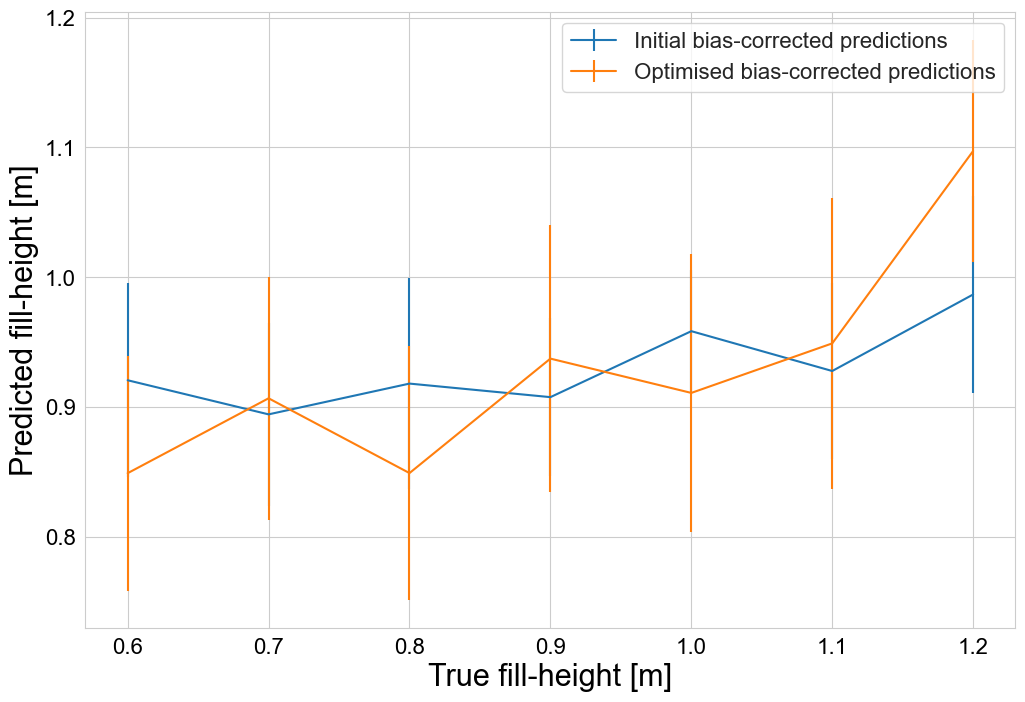

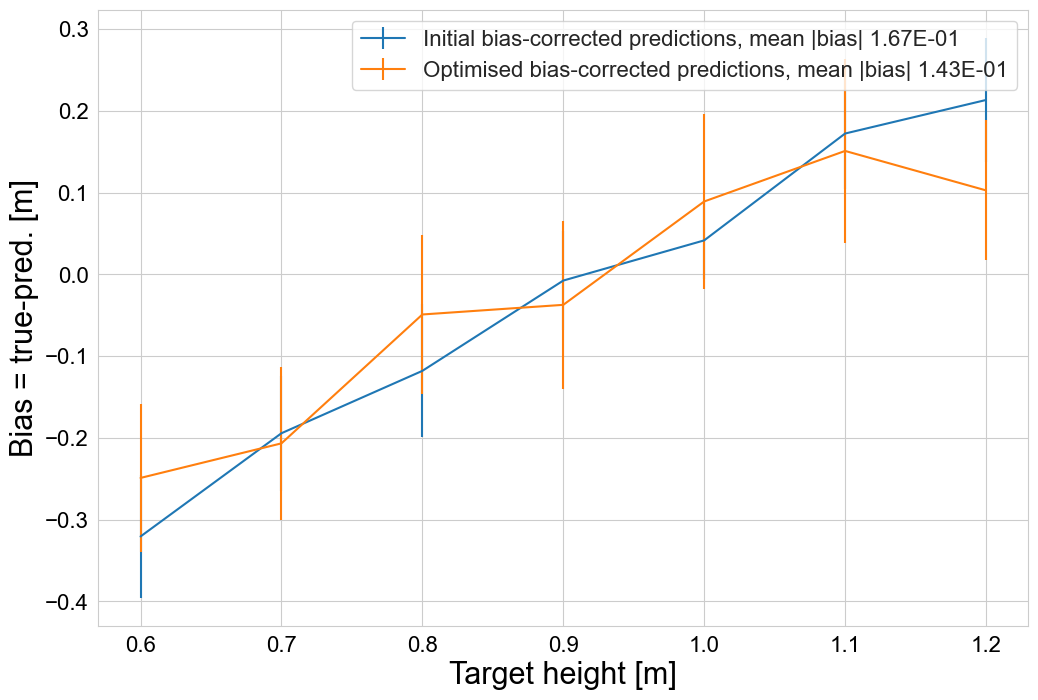

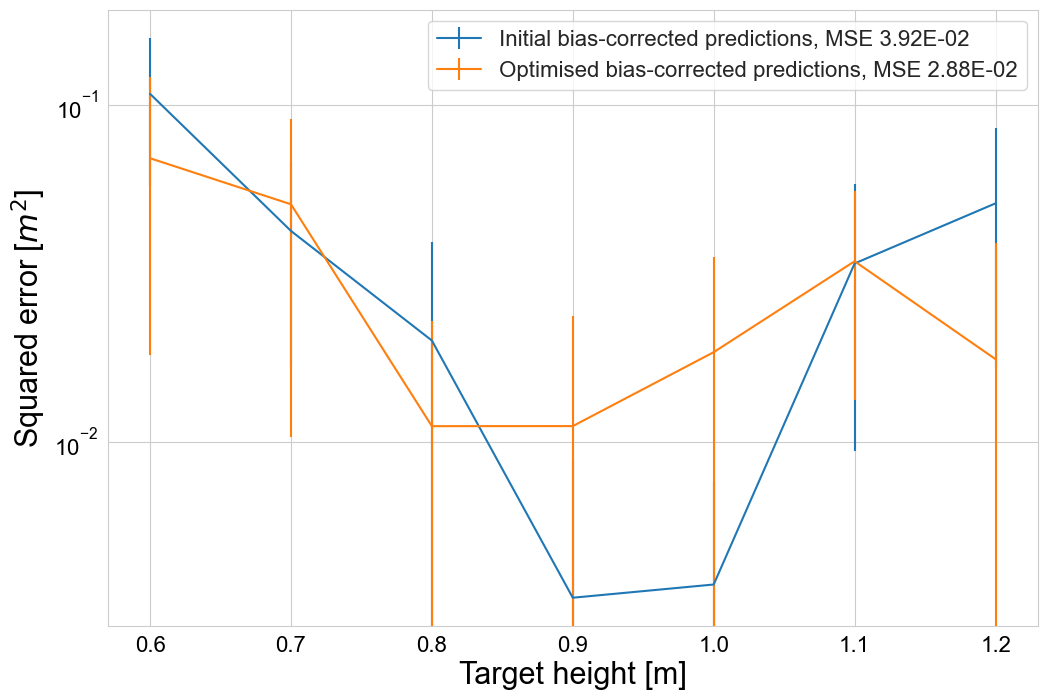

In [77]:
compare_init_to_optimised(df_start=df_start, df_opt=df_opt, NAME=NAME)

So, the optimised detector definitely improves on the starting detector. Let's see if we can further refine it.

## Second round

wrapper.load(f'train_weights_{NAME}_1/saved.pt')

We saw that the panels generally moved to be located above and below the passive volume. Since it's unlikely the optimisation will be able to perfectly centralise the panels, let's use our domain knowledge about the symmetry of the problem to assume that the optimal positions are directly above and below the volume. For the refinement, we'll then aim to just learn the optimal z-positions of the detectors, and associated sizes.

In [78]:
for l in volume.get_detectors():
    for p in l.panels:
        p.xy.data = Tensor([0.5,0.5])
        p.smooth = torch.tensor(0.1)

In [79]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6453]), and xy span tensor([0.9402, 0.9402]) with budget scale 1.1752270460128784
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5670]), and xy span tensor([1.3089, 1.3089]) with budget scale 1.6361002922058105
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4009]), and xy span tensor([0.6072, 0.6072]) with budget scale 0.7589375376701355
        (3): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4006]), and xy span tensor([1.0071, 1.0071]) with budget scale 1.2588834762573242
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
 

In [80]:
linear_correction = LinearCorrectionCallback(partial(torch.optim.SGD, lr=3e-1), init_weight=corr_layer.weight.item(), init_bias=corr_layer.bias.item())

In [81]:
opt_config = OptConfig(n_warmup=5, rates={'z_pos_upper':0.01, 'z_pos_lower':0.01, 'budget_weights':0.1})

In [82]:
wrapper.set_opt_lr(0.0, 'xy_pos_upper')
wrapper.set_opt_lr(0.0, 'xy_pos_lower')

Again, we'll rerun the learning rate finder, since the detectors have changed quite a bit since we first ran it.

1 warmup callbacks found, with a total warmup period of 5 epochs.


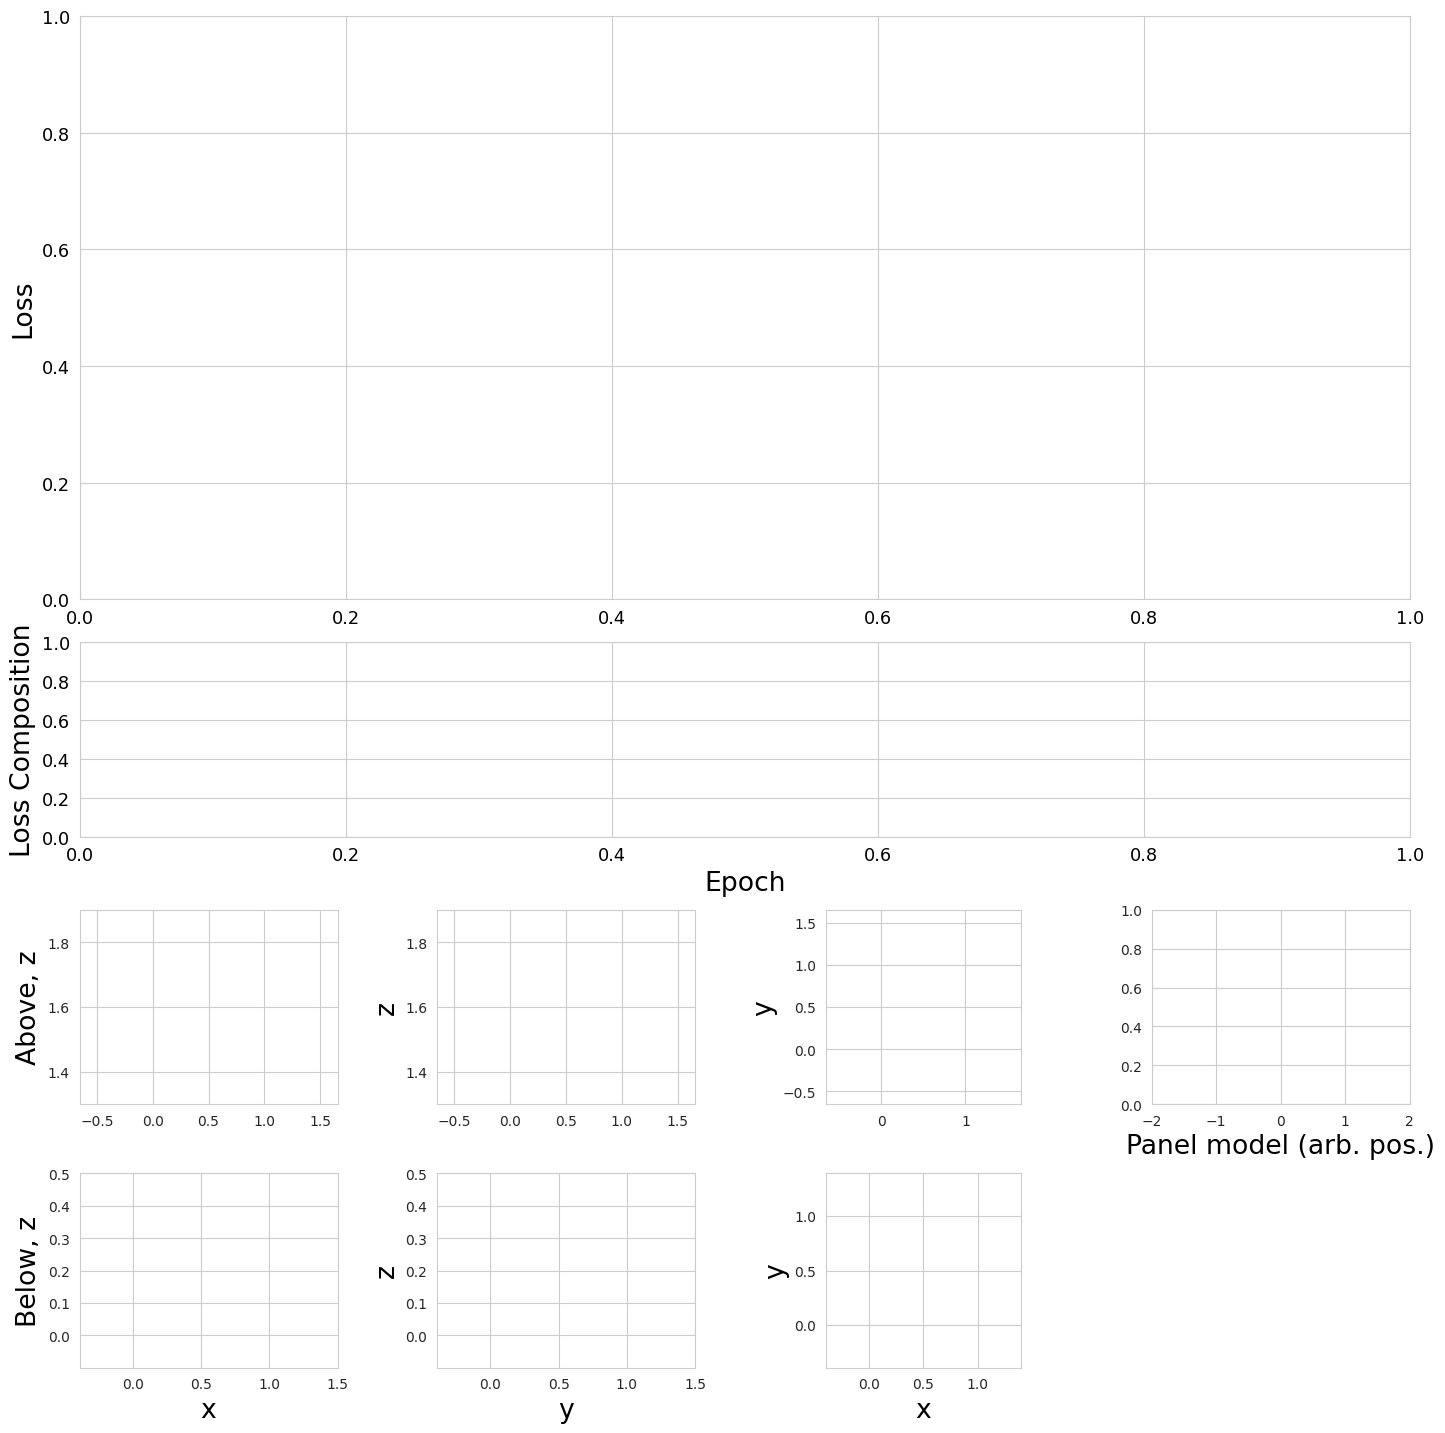

OptConfig: Optimiser warm-up completed
+----------------+-------------+----------------------+
|     Param      | Median Grad |          LR          |
+----------------+-------------+----------------------+
|  z_pos_upper   |   2.914827  | 0.003430735212815722 |
|  z_pos_lower   |   3.996499  | 0.002502190003276355 |
| budget_weights | 0.012105793 |   8.26050816956054   |
+----------------+-------------+----------------------+


<Figure size 1422.22x1422.22 with 0 Axes>

In [83]:
_ = wrapper.fit(n_epochs=5,
                passive_bs=len(trn_passives),
                n_mu_per_volume=1000,
                mu_bs=250,
                trn_passives=trn_passives,
                val_passives=None,
                cbs=[MuonResampler(), linear_correction, SpreadRangeLoss(), NoMoreNaNs(),
                     opt_config,
                     PanelCentring(), PanelMetricLogger()])

In [84]:
opt_config.lrs

{'z_pos_upper': 0.003430735212815722,
 'z_pos_lower': 0.002502190003276355,
 'budget_weights': 8.26050816956054}

opt_config.lrs = {'z_pos_upper': 0.00523587766810362,
 'z_pos_lower': 0.006289747075719527,
 'budget_weights': 20.89638687772811}

In [85]:
wrapper.set_opt_lr(0.0, 'xy_pos_upper')
wrapper.set_opt_lr(0.0, 'xy_pos_lower')

0 warmup callbacks found, with a total warmup period of 0 epochs.


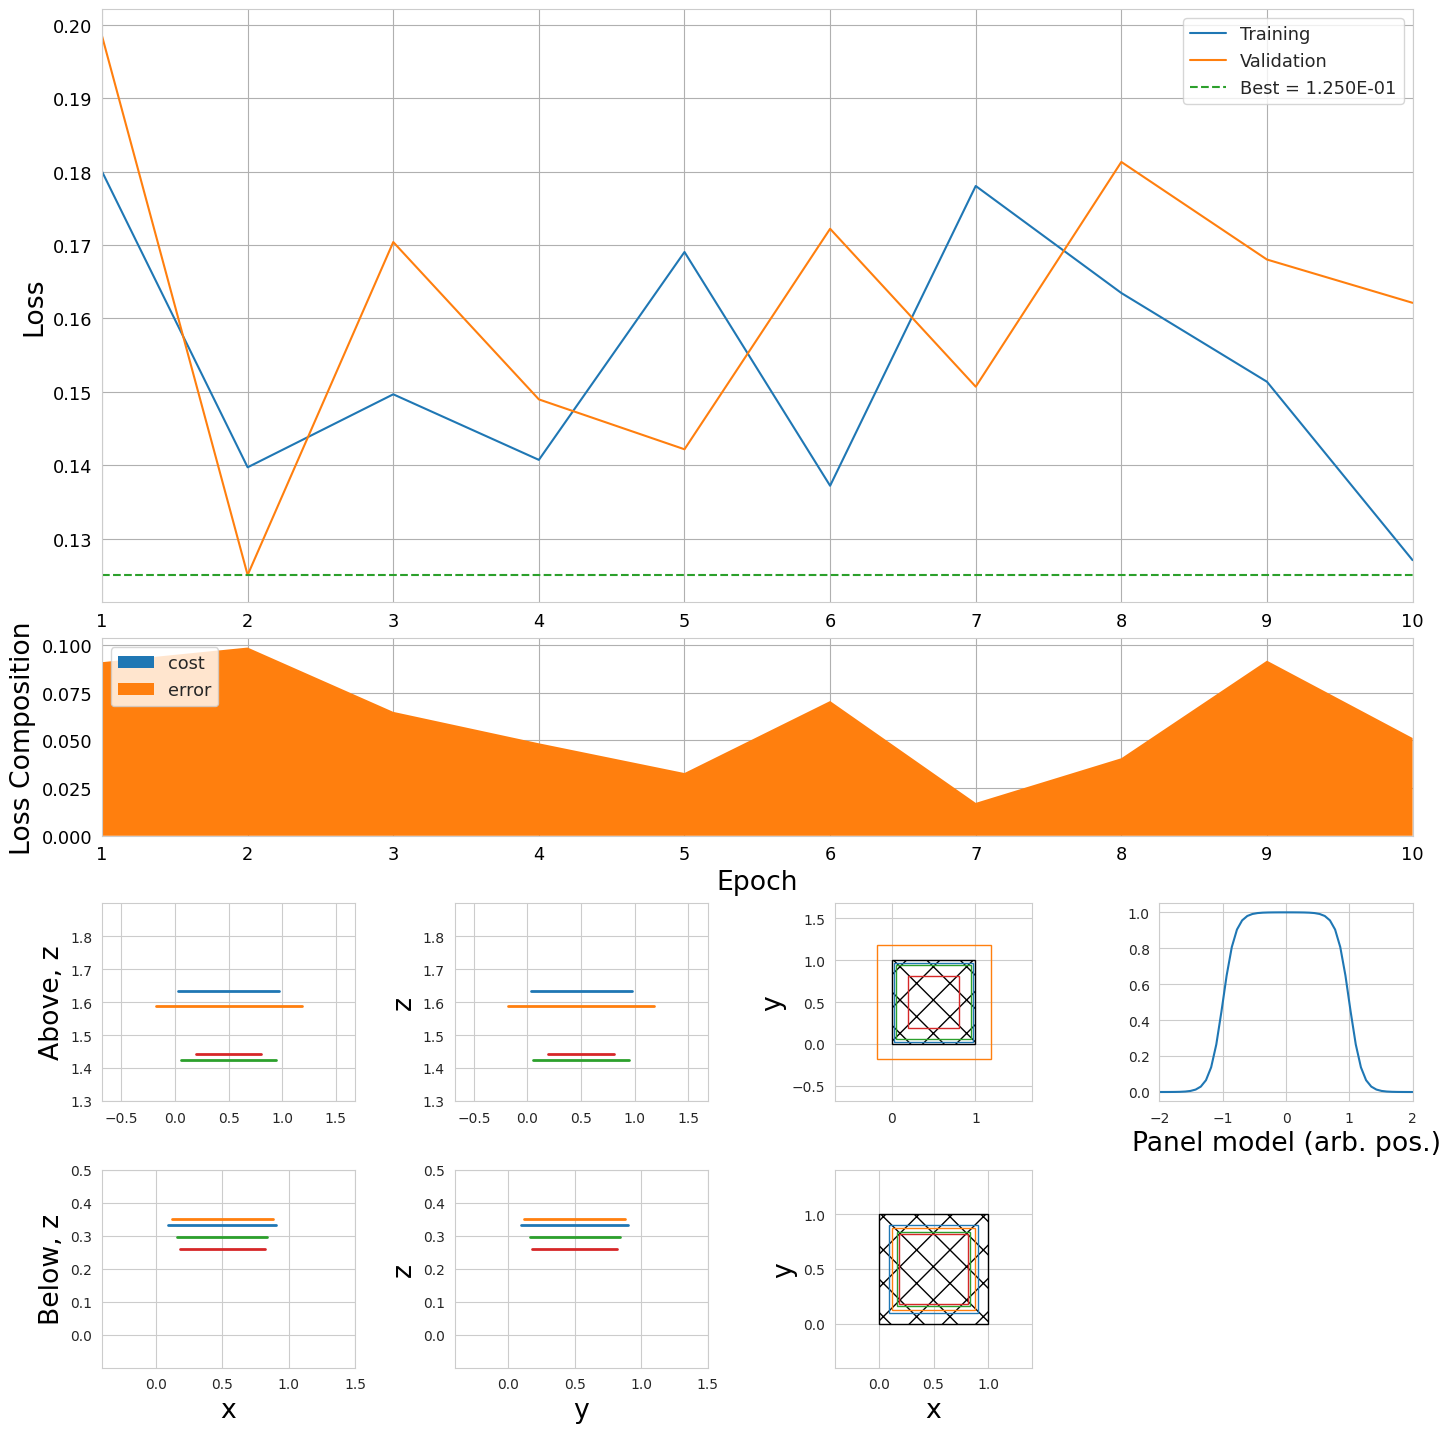

/home/geant/Desktop/TASKS/TomOpt/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:219: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


<Figure size 1422.22x1422.22 with 0 Axes>

In [86]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=len(trn_passives),
                n_mu_per_volume=1000,
                mu_bs=250,
                trn_passives=trn_passives,
                val_passives=trn_passives,
                cb_savepath=Path(f'train_weights_{NAME}_2'),
                cbs=[EpochSave(),
                    OneCycle('z_pos_upper', warmup_length=1, init_lr=opt_config.lrs['z_pos_upper'], mid_lr=opt_config.lrs['z_pos_upper'], final_lr=opt_config.lrs['z_pos_upper']/2),
                    OneCycle('z_pos_lower', warmup_length=1, init_lr=opt_config.lrs['z_pos_lower'], mid_lr=opt_config.lrs['z_pos_lower'], final_lr=opt_config.lrs['z_pos_lower']/2),
                    OneCycle('budget_weights', warmup_length=1, init_lr=opt_config.lrs['budget_weights']/10, mid_lr=opt_config.lrs['budget_weights']/10, final_lr=opt_config.lrs['budget_weights']/20),
                     MuonResampler(), linear_correction, SpreadRangeLoss(), NoMoreNaNs(), PanelCentring(), PanelMetricLogger()])

In [87]:
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6335]), and xy span tensor([0.9427, 0.9427]) with budget scale 1.178384780883789
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5879]), and xy span tensor([1.3612, 1.3612]) with budget scale 1.7015012502670288
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4237]), and xy span tensor([0.8891, 0.8891]) with budget scale 1.1113778352737427
        (3): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4437]), and xy span tensor([0.6141, 0.6141]) with budget scale 0.7676780223846436
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
  

In [88]:
wrapper.save(f'train_weights_{NAME}_2/saved.pt')

## Optimised performance

wrapper.load(f'train_weights_{NAME}_2/saved.pt')

In [101]:
preds = wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler(), linear_correction])

In [104]:
df_opt_2 = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_opt_2['gen_target'] = volume.passive_size*((df_opt_2.gen_target/volume.passive_size)//1)
df_opt_2['bias'] = (df_opt_2.gen_target-df_opt_2.pred)
df_opt_2['mse'] = df_opt_2.bias**2

In [105]:
df_opt_2.mse.mean()

0.0037040997

In [106]:
x = Tensor(df_opt_2.pred.values)[:,None]
y = Tensor(df_opt_2.gen_target.values)[:,None]

In [107]:
corr_layer = nn.Linear(1,1)
corr_layer.weight.data[0] = 1.0
corr_layer.bias.data[0] = 0.0

In [108]:
opt = torch.optim.SGD(corr_layer.parameters(), lr=3e-1)
mse = nn.MSELoss()

In [109]:
for i in range(10000):
    y_pred = corr_layer(x)
    loss = mse(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(loss)

tensor(0.0010, grad_fn=<MseLossBackward0>)


In [110]:
corr_layer.weight, corr_layer.bias

(Parameter containing:
 tensor([[0.8207]], requires_grad=True),
 Parameter containing:
 tensor([0.1892], requires_grad=True))

In [111]:
preds = wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler(), linear_correction])

In [112]:
df_opt_2 = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_opt_2['gen_target'] = volume.passive_size*((df_opt_2.gen_target/volume.passive_size)//1)
df_opt_2['new_pred'] = corr_layer(Tensor(df_opt_2.pred.values[:,None])).detach().cpu().numpy()
df_opt_2['new_bias'] = df_opt_2.gen_target-df_opt_2.new_pred
df_opt_2['new_mse'] = df_opt_2.new_bias**2

In [113]:
df_opt_2.new_mse.mean(), df_opt_2.new_bias.abs().mean()

(0.0011332126, 0.025141058)

In [114]:
from tomopt.benchmarks.ladle_furnace import compare_init_optimised_2

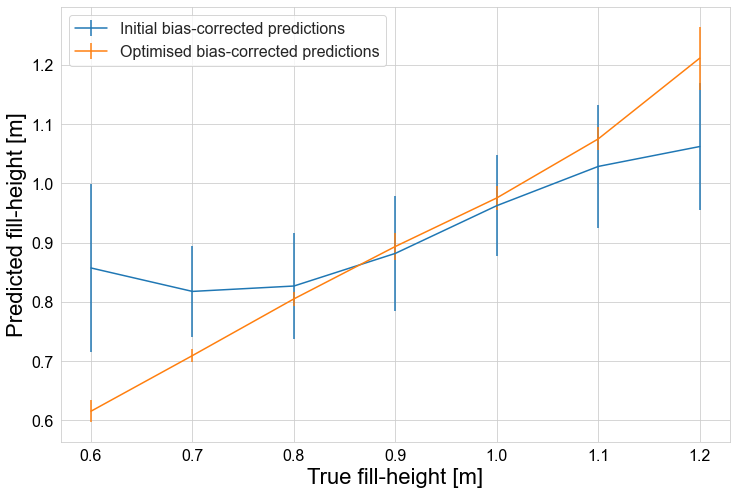

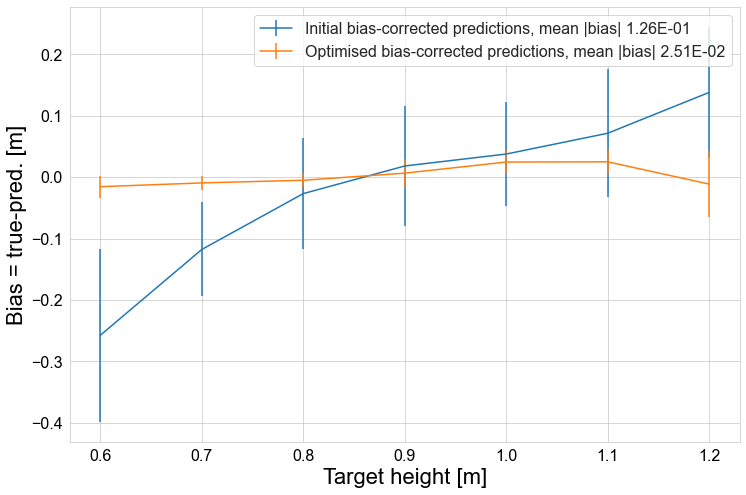

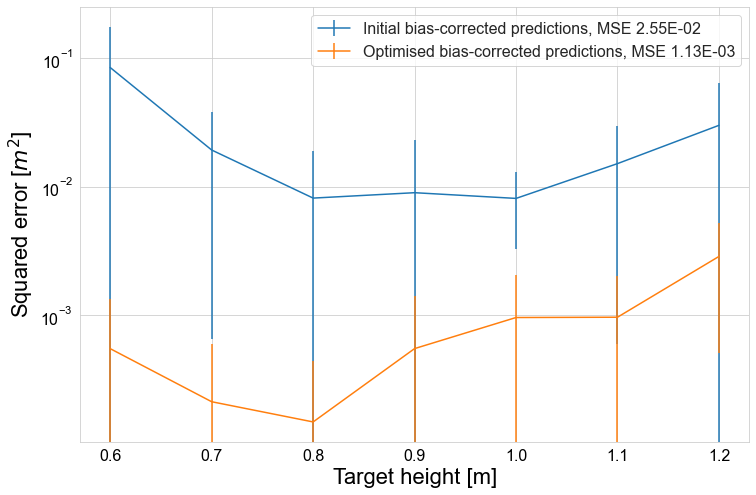

In [115]:
compare_init_optimised_2(df_start=df_start, df_opt_2=df_opt_2, NAME=NAME)

# Baselines 

We saw that the optimisation was able to improve over the initial starting detector, however the initial detector was deliberately designed to have poor performance to demonstrate the optimisation procedure. What we are really interested in is whether the optimiser is able to arrive at detectors that could match performance of human-designed ones. In this final step, we'll compare against to baseline detectors:

- The first, creates pairs of panels, with a large separation between them, aiming to maximise trajectory reconstruction resolution, whilst ignoring muon efficiency.
- The second distributed panels evenly in space, attempting to perform a trade-off between muon efficiency and trajectory precision.

Both detectors use the same size for every panel.

In [116]:
from tomopt.benchmarks.ladle_furnace import get_baseline_detector_1, get_baseline_detector_2

In [118]:
baseline_1_wrapper = ArbVolumeWrapper(Volume(get_baseline_detector_1(), budget=6),
                             opts=opts,
                             loss_func=VolumeMSELoss(target_budget=None),
                             partial_volume_inferrer=partial(PocaZLadleFurnaceFillLevelInferrer, smooth=1.0))

In [119]:
baseline_1_wrapper.volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.8000]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.7500]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (3): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4500]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
 

In [120]:
preds = baseline_1_wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler()])

In [121]:
df_bl_1 = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_bl_1['gen_target'] = baseline_1_wrapper.volume.passive_size*((df_bl_1.gen_target/baseline_1_wrapper.volume.passive_size)//1)

In [122]:
x = Tensor(df_bl_1.pred.values)[:,None]
y = Tensor(df_bl_1.gen_target.values)[:,None]

In [123]:
corr_layer = nn.Linear(1,1)
corr_layer.weight.data[0] = 1.0
corr_layer.bias.data[0] = 0.0

In [124]:
opt = torch.optim.SGD(corr_layer.parameters(), lr=3e-1)
mse = nn.MSELoss()

In [125]:
for i in range(10000):
    y_pred = corr_layer(x)
    loss = mse(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(loss)

tensor(0.0011, grad_fn=<MseLossBackward0>)


In [126]:
preds = baseline_1_wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler()])

In [127]:
df_bl_1 = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_bl_1['gen_target'] = baseline_1_wrapper.volume.passive_size*((df_bl_1.gen_target/baseline_1_wrapper.volume.passive_size)//1)
df_bl_1['new_pred'] = corr_layer(Tensor(df_bl_1.pred.values[:,None])).detach().cpu().numpy()
df_bl_1['new_bias'] = df_bl_1.gen_target-df_bl_1.new_pred
df_bl_1['new_mse'] = df_bl_1.new_bias**2

In [128]:
baseline_2_wrapper = ArbVolumeWrapper(Volume(get_baseline_detector_2(), budget=6),
                             opts=opts,
                             loss_func=VolumeMSELoss(target_budget=None),
                             partial_volume_inferrer=partial(PocaZLadleFurnaceFillLevelInferrer, smooth=1.0))

In [129]:
baseline_2_wrapper.volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.7500]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6500]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5500]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
        (3): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.4500]), and xy span tensor([0.8660, 0.8660]) with budget scale 1.0825316905975342
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
 

In [130]:
preds = baseline_2_wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler()])

In [131]:
df_bl_2 = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_bl_2['gen_target'] = baseline_2_wrapper.volume.passive_size*((df_bl_2.gen_target/baseline_2_wrapper.volume.passive_size)//1)

In [132]:
x = Tensor(df_bl_2.pred.values)[:,None]
y = Tensor(df_bl_2.gen_target.values)[:,None]

In [133]:
corr_layer = nn.Linear(1,1)
corr_layer.weight.data[0] = 1.0
corr_layer.bias.data[0] = 0.0

In [134]:
opt = torch.optim.SGD(corr_layer.parameters(), lr=3e-1)
mse = nn.MSELoss()

In [135]:
for i in range(10000):
    y_pred = corr_layer(x)
    loss = mse(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(loss)

tensor(0.0011, grad_fn=<MseLossBackward0>)


In [136]:
preds = baseline_2_wrapper.predict(test_passives,
                        n_mu_per_volume=1000,
                        mu_bs=1000,
                        pred_cb=VolumeTargetPredHandler(),
                        cbs=[MuonResampler()])

In [137]:
df_bl_2 = pd.DataFrame(np.array(preds).flatten().reshape(-1,2), columns=['pred', 'gen_target'])
df_bl_2['gen_target'] = baseline_2_wrapper.volume.passive_size*((df_bl_2.gen_target/baseline_2_wrapper.volume.passive_size)//1)
df_bl_2['new_pred'] = corr_layer(Tensor(df_bl_2.pred.values[:,None])).detach().cpu().numpy()
df_bl_2['new_bias'] = df_bl_2.gen_target-df_bl_2.new_pred
df_bl_2['new_mse'] = df_bl_2.new_bias**2

In [138]:
from tomopt.benchmarks.ladle_furnace import compare_optimised_to_baselines

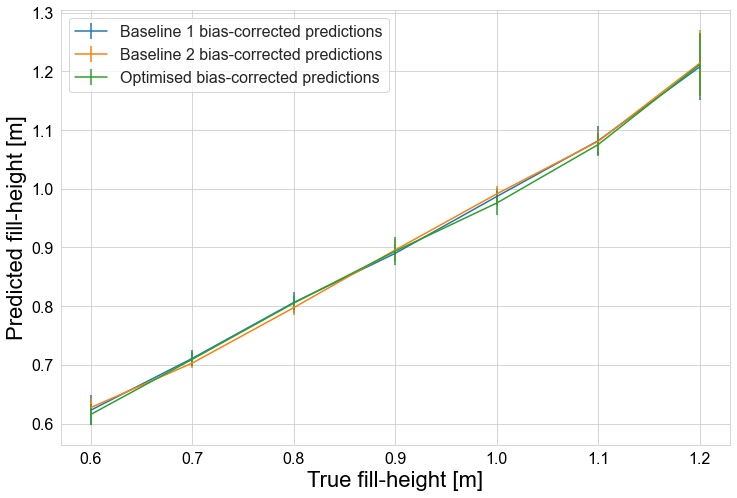

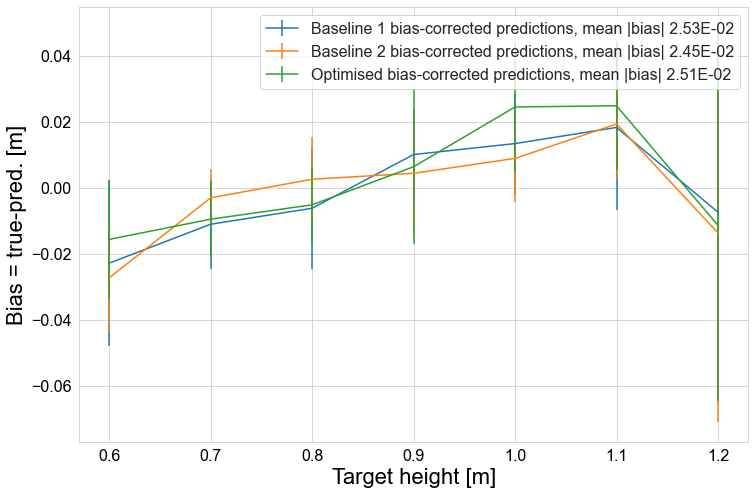

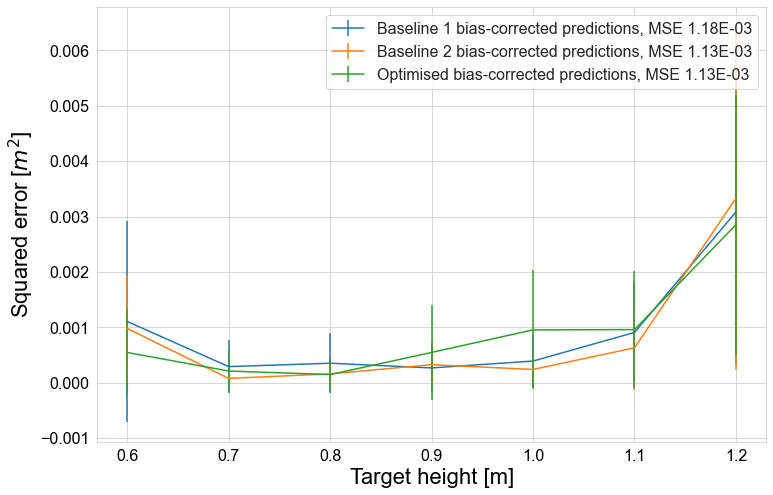

In [139]:
compare_optimised_to_baselines(df_bl_1=df_bl_1, df_bl_2=df_bl_2, df_opt_2=df_opt_2, NAME=NAME)

So, in the end we were able to match the performance of the human-designed detectors, in a mostly-automated fashion.